In [100]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
# from scipy.ndimage import convolve
from cv2 import filter2D
from skimage.feature import peak_local_max

import useful as us
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
from scipy.ndimage import convolve
import skimage.feature

In [101]:
data_dir = 'data_week2/'

In [102]:
def gaussians(s, n=4):
    """
    Generates Gaussian kernels and their first and second derivatives.

    Parameters:
    s (float): The standard deviation of the Gaussian distribution.
    n (int, optional): The range multiplier to determine the kernel size. 
                       The range of x values will be from -n*s to +n*s. Default is 4.

    Returns:
    tuple: A tuple containing three numpy arrays:
        - g: The Gaussian kernel.
        - dg: The first derivative of the Gaussian kernel.
        - ddg: The second derivative of the Gaussian kernel.

    The Gaussian kernel is defined as:
        g(x) = (1 / (s * sqrt(2 * pi))) * exp(-x^2 / (2 * s^2))

    The first derivative of the Gaussian kernel is defined as:
        dg(x) = -x / (s^2) * g(x)

    The second derivative of the Gaussian kernel is defined as:
        ddg(x) = -x / (s^2) * dg(x) - 1 / (s^2) * g(x)

    Example:
    >>> g, dg, ddg = gaussians(1.0, 4)
    >>> print(g)    # Gaussian kernel
    >>> print(dg)   # First derivative of the Gaussian kernel
    >>> print(ddg)  # Second derivative of the Gaussian kernel
    """

    # Create a range of x values centered around zero, from -n*s to +n*s
    x = np.arange(-np.ceil(n*s), np.ceil(n*s) + 1)
    x = np.reshape(x, (-1, 1))  # Reshape x into a column vector

    # Gaussian kernel
    g = 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-x**2 / (2 * s**2))
    
    # First derivative of the Gaussian kernel
    dg = -x / (s**2) * g
    
    # Second derivative of the Gaussian kernel
    ddg = -x / (s**2) * dg - 1 / (s**2) * g
    
    return g, dg, ddg

In [103]:
def laplacian_of_gaussian(im, g, ddg):
    """
    Compute the Laplacian of Gaussian (LoG) of an image.

    Parameters:
    im (numpy.ndarray): Input image.
    g (numpy.ndarray): Gaussian kernel.
    ddg (numpy.ndarray): Second derivative of the Gaussian kernel.

    Returns:
    numpy.ndarray: Image after applying the Laplacian of Gaussian.
    """
    # Convolve image with second-order Gaussian derivatives in x and y directions
    Lxx = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg), g.T)
    Lyy = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg.T), g)

    # Laplacian of Gaussian
    LoG = Lxx + Lyy

    return LoG

# Scale-space normalization

In [104]:
# Data
Lxx = 5.12
Lyy = 7.16
t = 12 # Variance of the Gaussian filter (sigma^2)

# Scale-normalized Laplacian
snL = t * (Lxx + Lyy)
print(f'Scale-normalized Laplacian: {snL:.2f}')

Scale-normalized Laplacian: 147.36


# Multiple scales

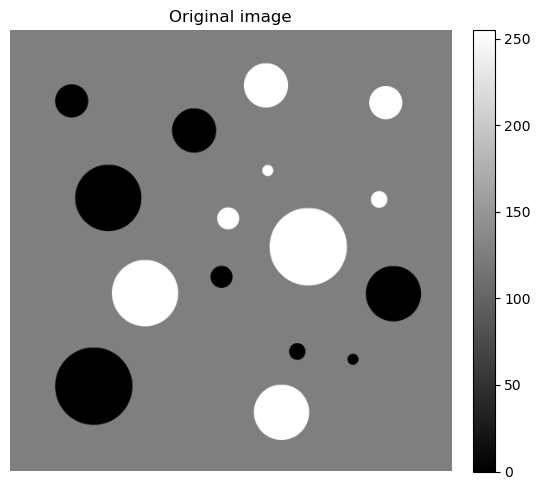

In [105]:
# Load the image
im = imread(data_dir + 'test_blob_varying.png').astype(np.float32)

# Display the image
us.display_images([im], ['Original image'])

# Parameters of the Gaussian filter
s = 2
g, dg, ddg = gaussians(s)
g2D = g @ g.T

# Scale-space initialization
n = 300  # number of scales to consider
t = s**2
t_values = np.arange(1, n + 1) * t # scale values

# Compute scale-space volume
L_blob_vol = np.zeros(im.shape + (n,))

Lg = im # Create a copy of the image

Scale-space volume shape: (512, 512, 300)


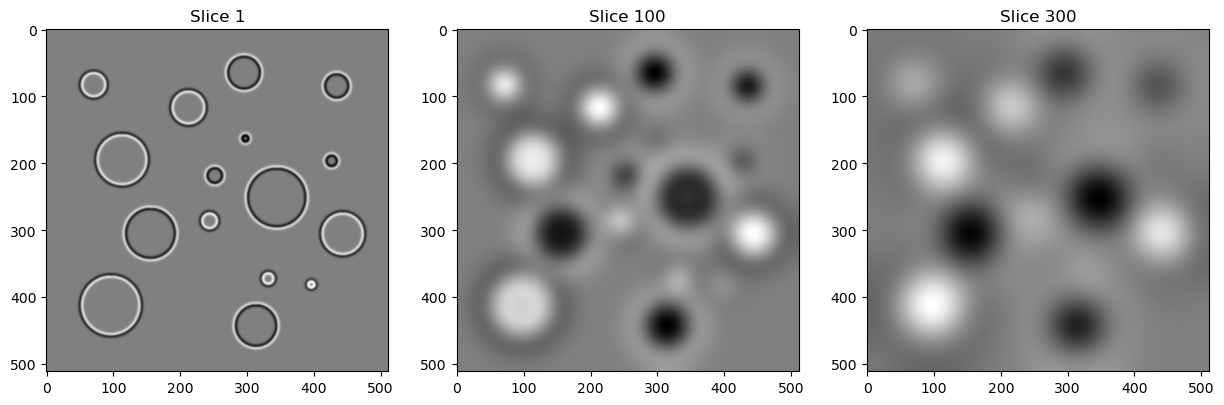

In [106]:
for i in range(n):
    L_blob_vol[:, :, i] = t_values[i] * laplacian_of_gaussian(Lg, g, ddg)

    # Apply 2D Gaussian filter to the image
    Lg = convolve(Lg, g2D)

print(f'Scale-space volume shape: {L_blob_vol.shape}')

# Show 3 slices of the scale-space volume
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(L_blob_vol[:, :, 0], cmap='gray')
plt.title('Slice 1')
plt.subplot(132)
plt.imshow(L_blob_vol[:, :, 100], cmap='gray')
plt.title('Slice 100')
plt.subplot(133)
plt.imshow(L_blob_vol[:, :, 299], cmap='gray')
plt.title('Slice 300')
plt.show()

[[382 397   4]
 [373 332  10]
 [287 245  19]
 [ 83  71  44]
 [117 213  77]
 [306 443 121]
 [196 114 168]
 [412  97 226]]


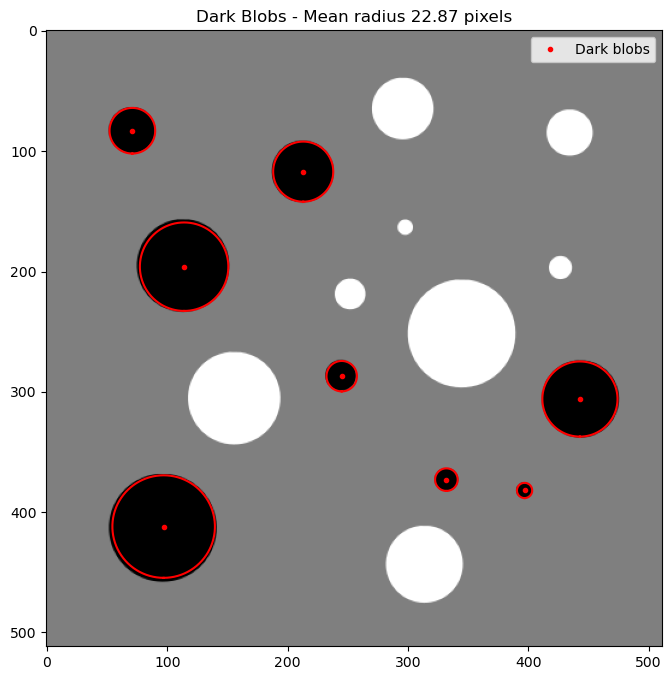

In [107]:
# Find the dark blobs in the image
coord_dark = peak_local_max(L_blob_vol, threshold_abs = 40)

# Show coords
print(coord_dark) # 2D coordinates of the dark blobs

# Visualize dark blobs
theta = np.linspace(0, 2 * np.pi, 91, endpoint=True)
circ = np.array((np.cos(theta), np.sin(theta)))

blob_radii_dark = np.sqrt(2 * t_values[coord_dark[:, 2]])
circ_y_dark = coord_dark[:, 0][:, np.newaxis] + np.outer(blob_radii_dark, circ[0])
circ_x_dark = coord_dark[:, 1][:, np.newaxis] + np.outer(blob_radii_dark, circ[1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord_dark[:, 1], coord_dark[:, 0], '.r', label='Dark blobs')
for i in range(len(blob_radii_dark)):
    ax.plot(circ_x_dark[i], circ_y_dark[i], 'r')
ax.set_title(f'Dark Blobs - Mean radius {blob_radii_dark.mean():0.2f} pixels')
ax.legend()
plt.show()

[[443 314 157]
 [ 65 296  91]
 [ 85 435  48]
 [219 252  20]
 [197 427  11]
 [163 298   4]]


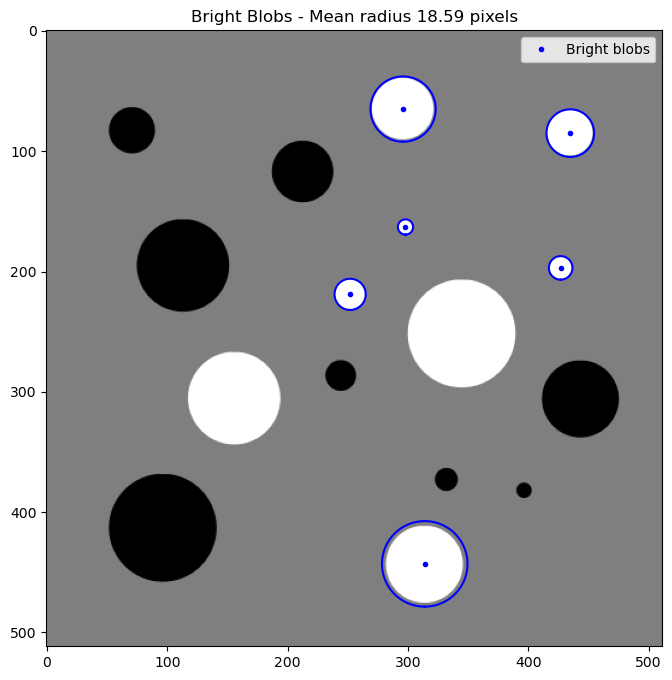

In [108]:
# Find the bright blobs in the image
coord_bright = peak_local_max(-L_blob_vol, threshold_abs = 40)

# Show coords
print(coord_bright) # 2D coordinates of the bright blobs

# Visualize bright blobs
blob_radii_bright = np.sqrt(2 * t_values[coord_bright[:, 2]])
circ_y_bright = coord_bright[:, 0][:, np.newaxis] + np.outer(blob_radii_bright, circ[0])
circ_x_bright = coord_bright[:, 1][:, np.newaxis] + np.outer(blob_radii_bright, circ[1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord_bright[:, 1], coord_bright[:, 0], '.b', label='Bright blobs')
for i in range(len(blob_radii_bright)):
    ax.plot(circ_x_bright[i], circ_y_bright[i], 'b')
ax.set_title(f'Bright Blobs - Mean radius {blob_radii_bright.mean():0.2f} pixels')
ax.legend()
plt.show()

# One scale (pre-computed)

In [109]:
data_dir = 'data_2022/'

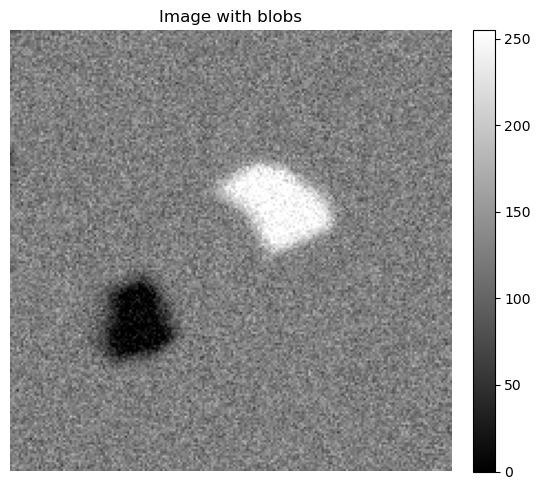

(30, 200, 200)
(200, 200, 30)


In [110]:
# Load the image with blobs
im = skimage.io.imread(f'{data_dir}blobs.png').astype(np.float32)

# Display the image
us.display_images([im], ['Image with blobs'])

# Open pre-computed linear laplacian scale-space
L_blob_vol = skimage.io.imread(f'{data_dir}blobs_Laplace.tif')
print(L_blob_vol.shape)

# Put the first dimension of L_blob_vol as the last dimension
L_blob_vol = np.moveaxis(L_blob_vol, 0, -1)
print(L_blob_vol.shape)

[[132  57   8]]


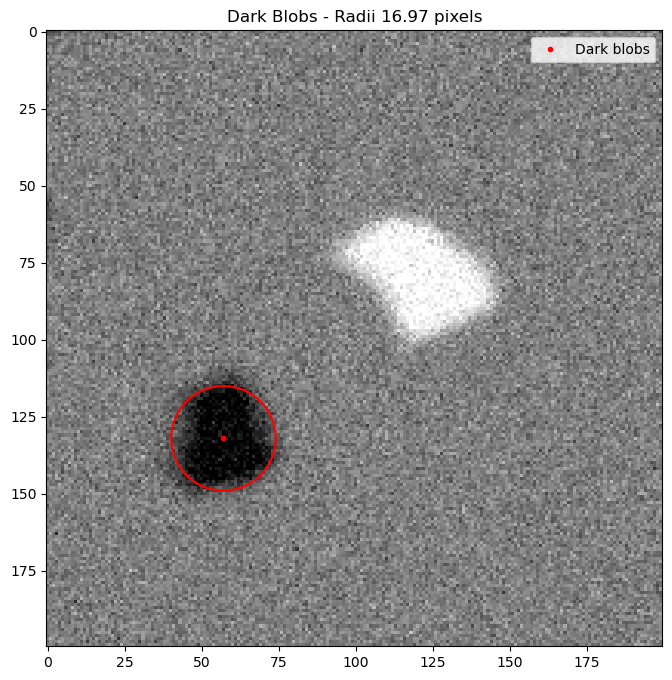

In [120]:
# Gaussian parameters
t = 16 # variance
s = np.sqrt(t) # sigma
g, dg, ddg = gaussians(s)

# Find the dark blobs in the image
coord_dark = peak_local_max(L_blob_vol, threshold_abs = 40)

# Show coords
print(coord_dark) # 2D coordinates of the dark blobs

# Visualize dark blobs
theta = np.linspace(0, 2 * np.pi, 91, endpoint=True)
circ = np.array((np.cos(theta), np.sin(theta)))

blob_radii_dark = np.sqrt(2 * (t*(coord_dark[:, 2]+1)))
circ_y_dark = coord_dark[:, 0][:, np.newaxis] + np.outer(blob_radii_dark, circ[0])
circ_x_dark = coord_dark[:, 1][:, np.newaxis] + np.outer(blob_radii_dark, circ[1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord_dark[:, 1], coord_dark[:, 0], '.r', label='Dark blobs')
for i in range(len(coord_dark)):
    ax.plot(circ_x_dark[i], circ_y_dark[i], 'r')
radii_str = ', '.join(f'{r:0.2f}' for r in blob_radii_dark)
ax.set_title(f'Dark Blobs - Radii {radii_str} pixels')
ax.legend()
plt.show()


[[ 80 122  11]]


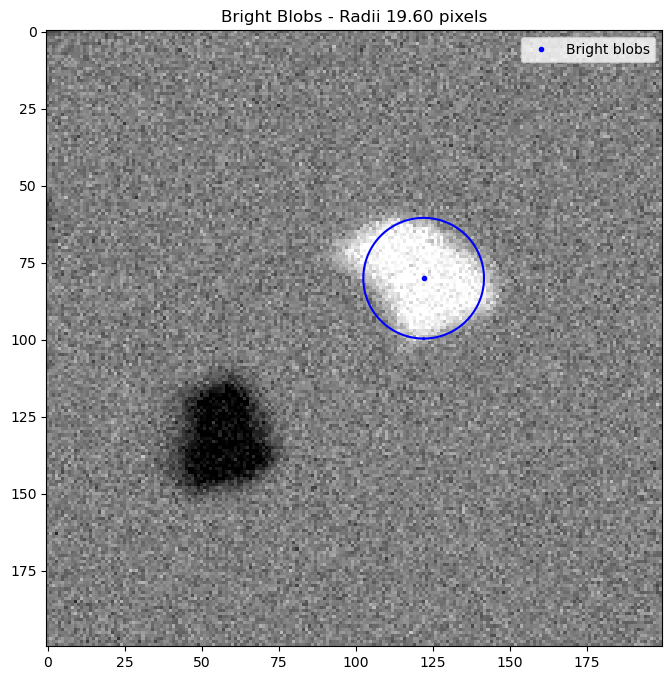

In [121]:
# Find the bright blobs in the image
coord_bright = peak_local_max(-L_blob_vol, threshold_abs=40)

# Show coordinates
print(coord_bright)  # 2D coordinates of the bright blobs

# Visualize bright blobs
theta = np.linspace(0, 2 * np.pi, 91, endpoint=True)
circ = np.array((np.cos(theta), np.sin(theta)))

blob_radii_bright = np.sqrt(2 * (t * (coord_bright[:, 2] + 1)))
circ_y_bright = coord_bright[:, 0][:, np.newaxis] + np.outer(blob_radii_bright, circ[0])
circ_x_bright = coord_bright[:, 1][:, np.newaxis] + np.outer(blob_radii_bright, circ[1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord_bright[:, 1], coord_bright[:, 0], '.b', label='Bright blobs')
for i in range(len(coord_bright)):
    ax.plot(circ_x_bright[i], circ_y_bright[i], 'b')
radii_str_bright = ', '.join(f'{r:0.2f}' for r in blob_radii_bright)
ax.set_title(f'Bright Blobs - Radii {radii_str_bright} pixels')
ax.legend()
plt.show()


# Average diameter

In [124]:
data_dir = 'data_2023/'

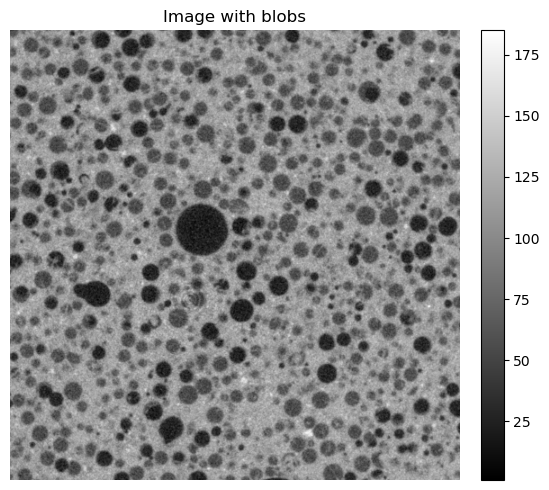

In [134]:
# Load the image with blobs
im = skimage.io.imread(f'{data_dir}cement.png').astype(np.float32)

# Display the image
us.display_images([im], ['Image with blobs'])

# Open pre-computed linear laplacian scale-space (txt)
data = np.loadtxt(f'{data_dir}cement.txt')

# Extract the data
beta = data[:, 0]
y_coord = data[:, 1]
x_coord = data[:, 2]
scale = data[:, 3]


In [137]:
# Discard blobs with abs(beta) > 10
idx = np.where(np.abs(beta) > 10)[0]

# Apply the mask
beta = beta[idx]
y_coord = y_coord[idx]
x_coord = x_coord[idx]
scale = scale[idx]

# Diameter = 2*radius = 2*sqrt(2*scale). Average diameter
diameter = 2*np.sqrt(2*scale).mean()

# Print the result
print(f'Average diameter: {diameter:.2f}')

Average diameter: 15.42


# Estimated radius

In [138]:
import numpy as np

# Laplacian of Gaussian (LoG) responses at different scales
L_1 = 28.9  # for t = 1
L_2 = 19.9  # for t = 2
L_3 = 13.7  # for t = 3
L_4 = 9.8   # for t = 4
L_5 = 7.0   # for t = 5

# Store the LoG responses and corresponding scales in arrays
L = np.array([L_1, L_2, L_3, L_4, L_5])
t = np.array([1, 2, 3, 4, 5])

# Compute the product of LoG responses and their respective scales
L_blob_vol = L * t

# Find the index of the maximum value in the L_blob_vol array
idx_max = np.argmax(L_blob_vol)

# Find the maximum value in the L_blob_vol array
max_value = np.max(L_blob_vol)

# Print the scale at which the maximum value occurs and the maximum value itself
print(f'Maximum at t = {t[idx_max]}')  # Large positive value: dark blob
print(f'Maximum value: {max_value:.2f}')

# Estimate the radius of the blob using the scale at the maximum response
radius = np.sqrt(2 * t[idx_max])

# Print the estimated radius
print(f'Estimated radius: {radius:.2f}')

Maximum at t = 3
Maximum value: 41.10
Estimated radius: 2.45
